### Forecasting - Jordan

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [3]:
# Locating events within Jordan
data = df.loc[df['country'] == 'Jordan', :]

In [4]:
data.shape

(376, 58)

In [5]:
# Dropping unecessary modeling columns
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [6]:
# Calculating weekly event count
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [7]:
df.head()

,date,count
0,2018-05-31,9
1,2019-06-11,7
2,2017-12-07,6
3,2019-09-09,6
4,2019-04-16,6


In [8]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [9]:
# Merging jordan events and weekly event counts
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [10]:
data.set_index('event_date', inplace=True)

In [11]:
data.drop(columns='date', inplace=True)

In [12]:
# Creating dummy variables from admin1 location
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,...,admin1_Al Balqa,admin1_Al Karak,admin1_Al Mafraq,admin1_Amman,admin1_At Tafilah,admin1_Az Zarqa,admin1_Irbid,admin1_Jerash,admin1_Maan,admin1_Madaba
event_date,,,,,,,,,,,,,,,,,,,,,
2017-01-06,30.1962,35.7341,3,1,66,61,1,0.0,0.7089,15.11,...,0,0,0,0,0,0,0,0,1,0
2017-01-15,31.9552,35.9450,1,0,77,66,1,0.0,0.7089,15.11,...,0,0,0,1,0,0,0,0,0,0
2017-01-21,33.3141,38.7034,1,11,72,65,1,0.0,0.7089,15.11,...,0,0,1,0,0,0,0,0,0,0
2017-02-11,31.1637,35.7620,1,0,267,65,2,0.0,0.7089,15.11,...,0,1,0,0,0,0,0,0,0,0
2017-02-14,31.9552,35.9450,1,0,342,53,2,0.0,0.7089,15.11,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06,31.9552,35.9450,1,0,43,64,12,0.0,0.7092,14.72,...,0,0,0,1,0,0,0,0,0,0
2019-12-08,31.9552,35.9450,1,0,50,59,12,0.0,0.7092,14.72,...,0,0,0,1,0,0,0,0,0,0
2019-12-21,31.9552,35.9450,1,0,50,54,12,0.0,0.7092,14.72,...,0,0,0,1,0,0,0,0,0,0


In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
minmax = MinMaxScaler()

In [20]:
# Normalizing numerical data
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(282, 39)

In [54]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [55]:
batch_x, batch_y = train[0]

In [56]:
batch_x.shape

(64, 3, 39)

In [57]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=32, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 3, 32)             9216      
_________________________________________________________________
dropout_28 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 3, 32)             8320      
_________________________________________________________________
dropout_29 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 3, 32)             8320      
_________________________________________________________________
dropout_30 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 96)              

In [58]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=100)

Epoch 1/100
5/5 [==============================] - 2s 400ms/step - loss: 99.7005 - val_loss: 98.9561
Epoch 2/100
5/5 [==============================] - 0s 12ms/step - loss: 98.7840 - val_loss: 97.8377
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 97.5202 - val_loss: 96.4918
Epoch 4/100
5/5 [==============================] - 0s 21ms/step - loss: 95.9749 - val_loss: 94.8290
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 93.2431 - val_loss: 92.6699
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 90.4077 - val_loss: 89.7413
Epoch 7/100
5/5 [==============================] - 0s 20ms/step - loss: 84.4754 - val_loss: 85.5876
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 73.9274 - val_loss: 79.7150
Epoch 9/100
5/5 [==============================] - 0s 21ms/step - loss: 66.3339 - val_loss: 73.0989
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 67.6324 - val_loss: 68.001

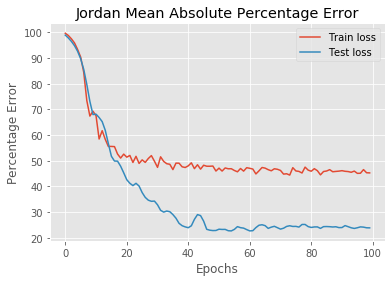

In [69]:

plt.style.use('ggplot')
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.title('Jordan Mean Absolute Percentage Error')
plt.xlabel('Epochs')
plt.ylabel('Percentage Error')
plt.legend()
plt.savefig('imgs/jordanloss.jpeg');

In [62]:
jordan_preds = model.predict(test)

In [66]:
def plot_predictions(test,predicted):
    plt.plot(test, label='True Values')
    plt.plot(predicted, label='Predicted Values')
    plt.title('Jordan Forecast')
    plt.xlabel('Time')
    plt.ylabel('Weekly Count of Events')
    plt.legend()
    plt.savefig('imgs/jordanforcast.jpeg')

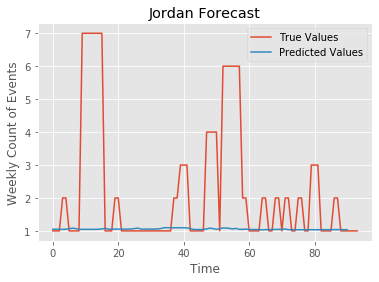

In [67]:
plot_predictions(y_test.values, jordan_preds)